In [1]:
# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotting_module

# calculation
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

In [2]:
dataset = xr.open_dataset("tco300_omimls_oct2004_to_dec2024_1by1.nc")

OMI/MLS Ground-to-300hPa Column Ozone for TOARII *y_elements: latitude, x_elements: longitude, period: October 2004 - December 2024

So now it is time for some data cleaning, there should not be negative values in the data

In [3]:
ozone = dataset["TropoO3"]
cleaned_ozone_dataset = ozone.where(ozone >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

In [4]:
ozone = cleaned_ozone_dataset 

# adding month from attributes to coordinate
month = ozone.attrs['Month'].split(',')
first_month = month[0]                              # October 2004
last_month = month[-1].replace(' ', '')             # December 2024

start_date = datetime.strptime(first_month, "%b%Y")
end_date = datetime.strptime(last_month, "%b%Y")

time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

In [5]:
# renaming and assigning/removing dimensions
ozone = ozone.assign_coords(time=('months', time_coords))
ozone = ozone.rename({"time": "yearmonth",'y_elements': 'latitude', 'x_elements': 'longitude'})
ozone = ozone.swap_dims({'months': 'yearmonth'})

Subsetting necessary months. This is January 2005 - December 2024 ONLY

In [6]:
ozone_subsetted = ozone.sel(yearmonth=slice("2005-01-01", "2024-12-01")) ####

In [7]:
ozone_mean_subsetted = ozone_subsetted.assign_attrs(_FillValue="-999",name="Tropospheric Ozone Mean, Ground to 300 hPa", latitude="-75.5, -59.5, -58.5, ..., 59.5, 75.5")
ozone_stdev_subsetted = ozone_subsetted.assign_attrs(_FillValue="-999",name="Tropospheric Ozone STDEV, Ground to 300 hPa", latitude="-75.5, -59.5, -58.5, ..., 59.5, 75.5")

del ozone_mean_subsetted.attrs['Month']
del ozone_stdev_subsetted.attrs['Month']

In [8]:
# adding lat/lon from attributes to coordinates
lat_coords = ozone_subsetted.attrs['latitude'].split(',')
first_lat = float(lat_coords[0])
last_lat = float(lat_coords[-1])

lon_coords = ozone_subsetted.attrs['longitude'].split(',')
first_lon = float(lon_coords[0])
last_lon = float(lon_coords[-1])

lon_coords = np.arange(first_lon, 180.5, 1)
lat_coords = np.arange(first_lat,90.5, 1)

ozone_mean_subsetted = ozone_mean_subsetted.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

ozone_stdev_subsetted = ozone_stdev_subsetted.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

In [9]:
# create to netcdf for future use in time series plots
#ozone_mean_subsetted.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/300hpa_full_monthly_omimls_tco.nc",format="NETCDF4")

In [10]:
# grouping by calendar month
monthly_mean = ozone_mean_subsetted.groupby('yearmonth.month').mean('yearmonth')
monthly_stdev = ozone_stdev_subsetted.groupby('yearmonth.month').std('yearmonth') # group it with means

# grouping by season
seasonal_mean = ozone_mean_subsetted.groupby('yearmonth.season').mean('yearmonth')
seasonal_stdev = ozone_stdev_subsetted.groupby('yearmonth.season').std('yearmonth')

In [11]:
monthly_mean[1].mean()

<xarray.DataArray 'TropoO3' ()> Size: 8B
array(21.59259987)
Coordinates:
    month    int64 8B 2

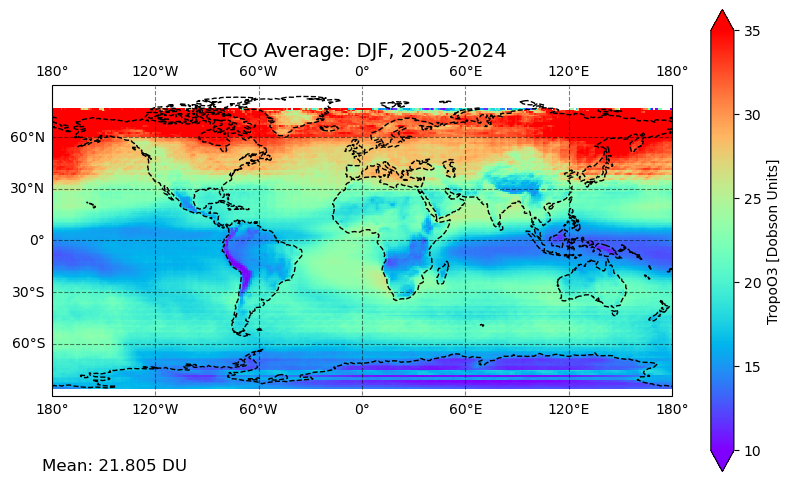

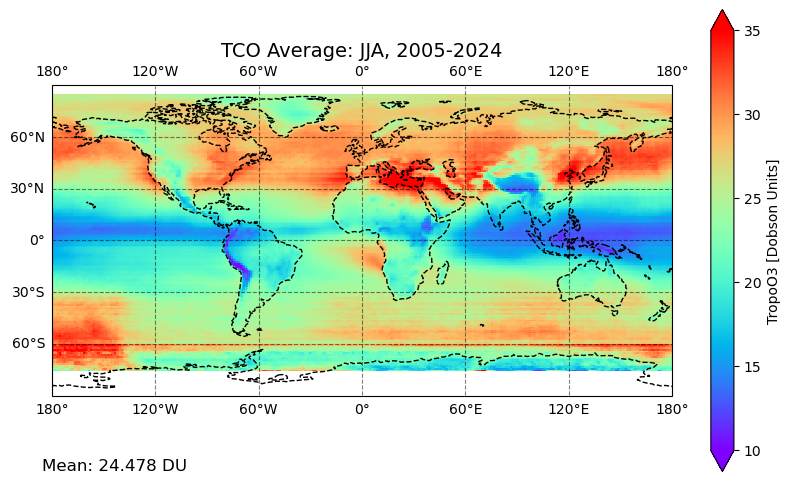

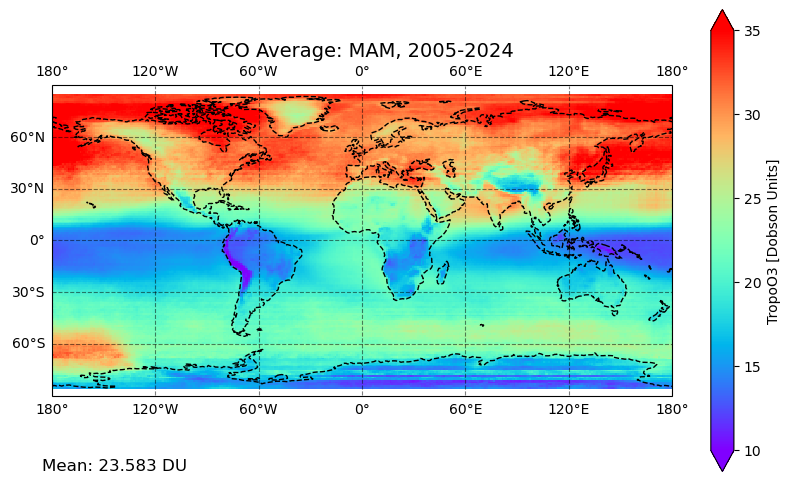

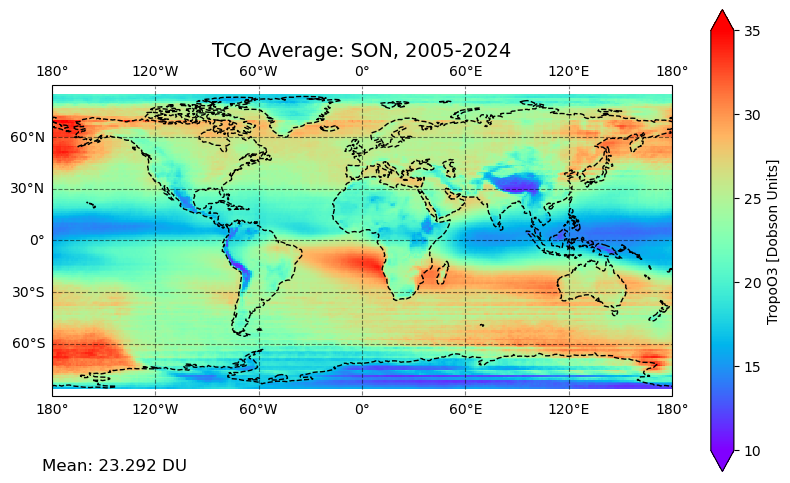

In [12]:
# plot the seasonal means

seasonal_list = ['DJF', 'JJA', 'MAM', 'SON']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

for i in range(4):
    plotting_module.plotting_ozone(seasonal_mean, i, "TCO Average:", seasonal_list, 10, 35, 'rainbow', True)

In [13]:
monthly_mean.std(dim={'month','latitude','longitude'}, skipna=True)

<xarray.DataArray 'TropoO3' ()> Size: 4B
array(5.8313584, dtype=float32)

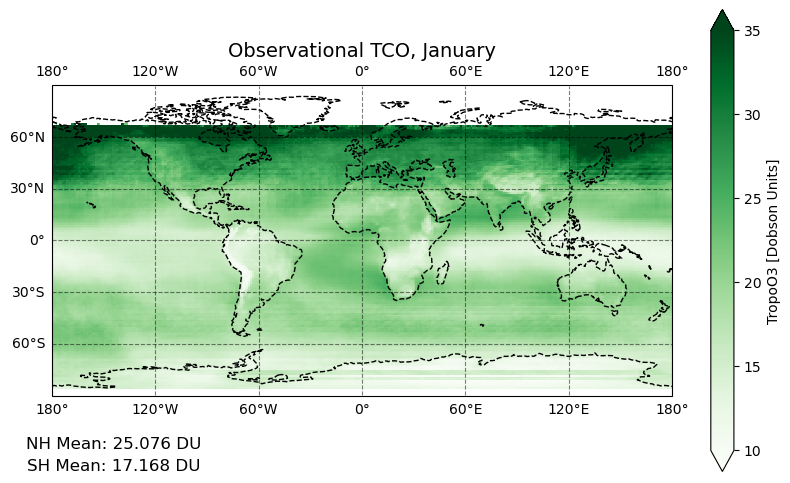

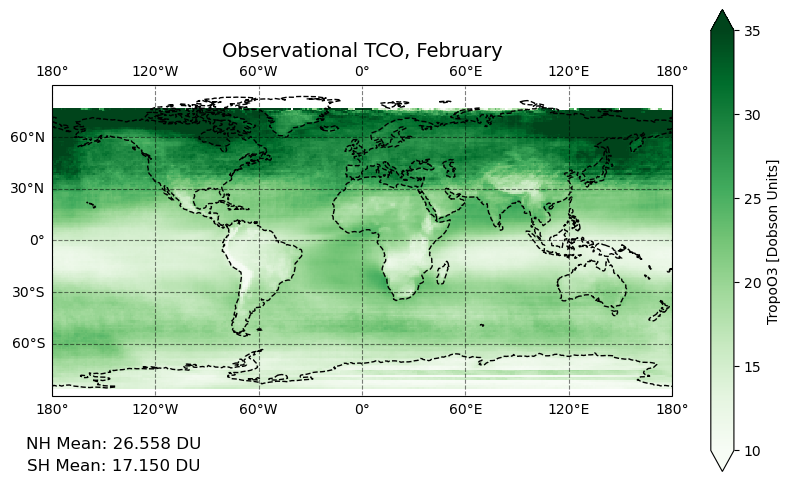

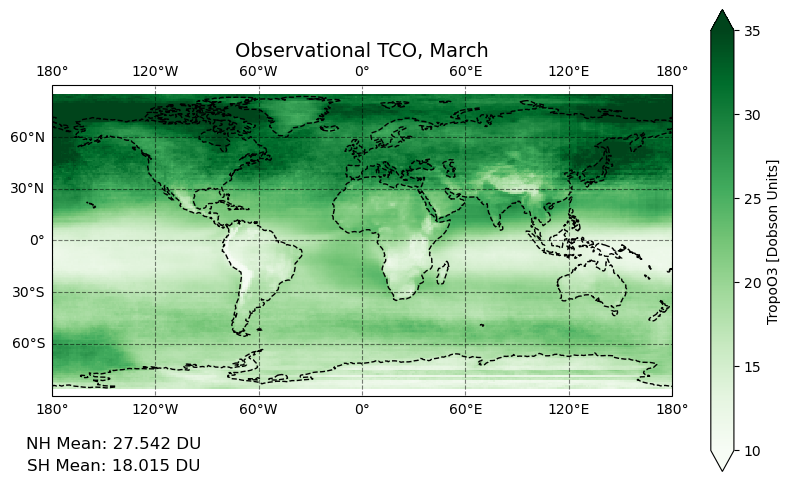

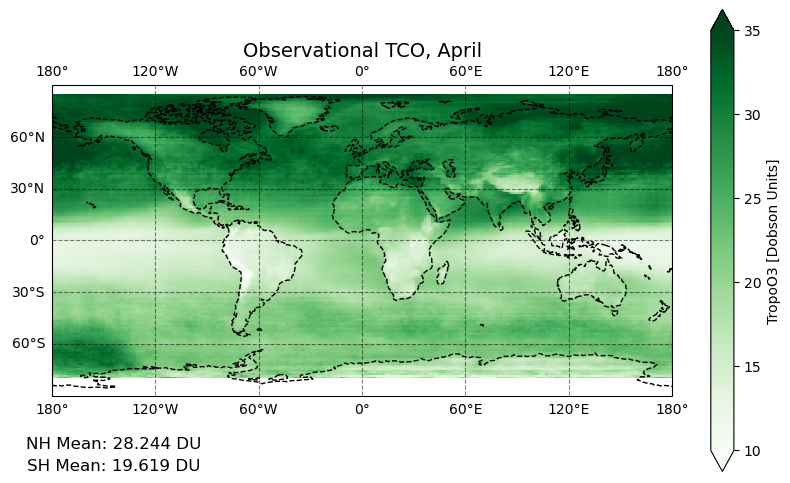

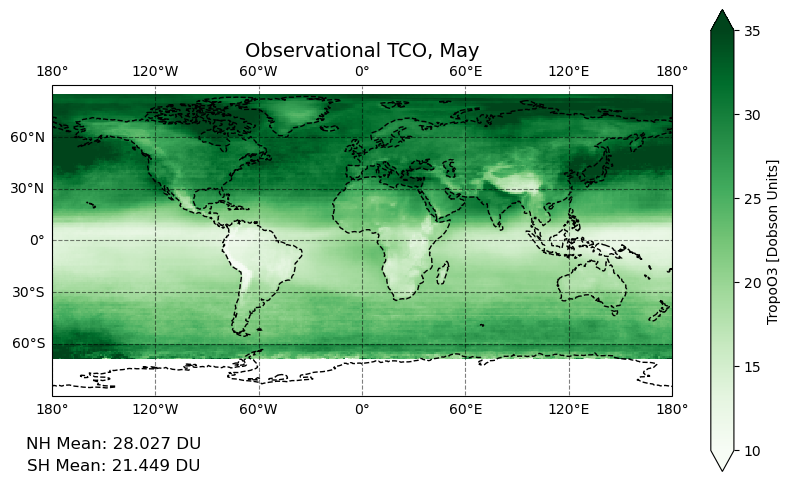

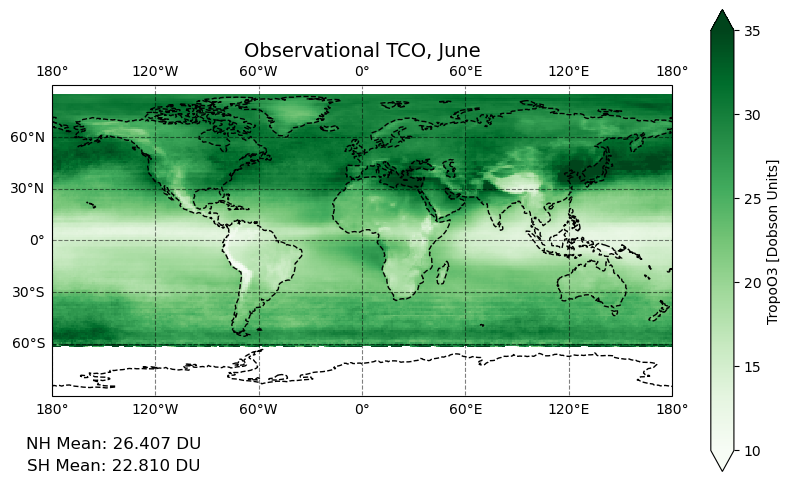

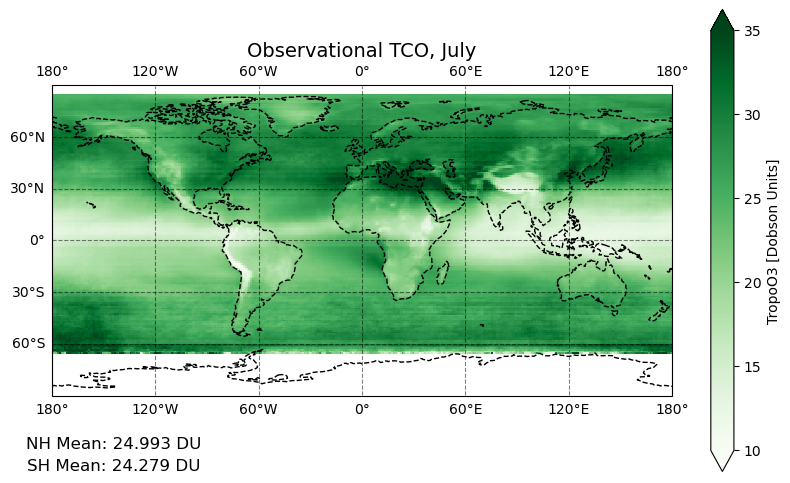

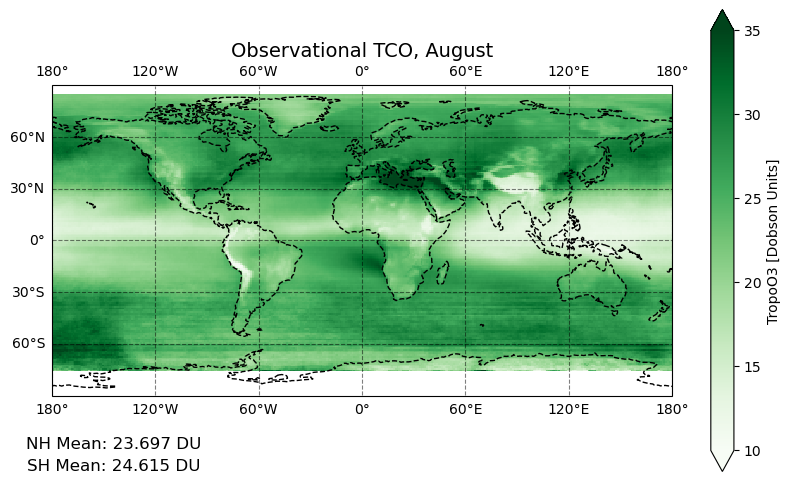

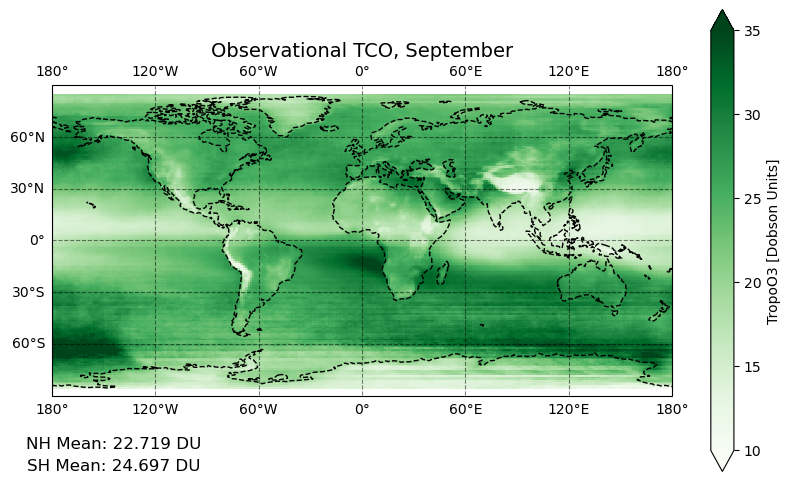

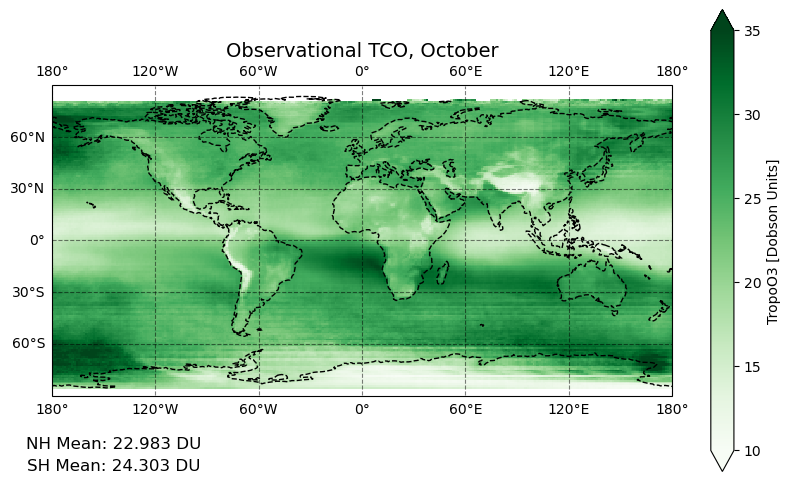

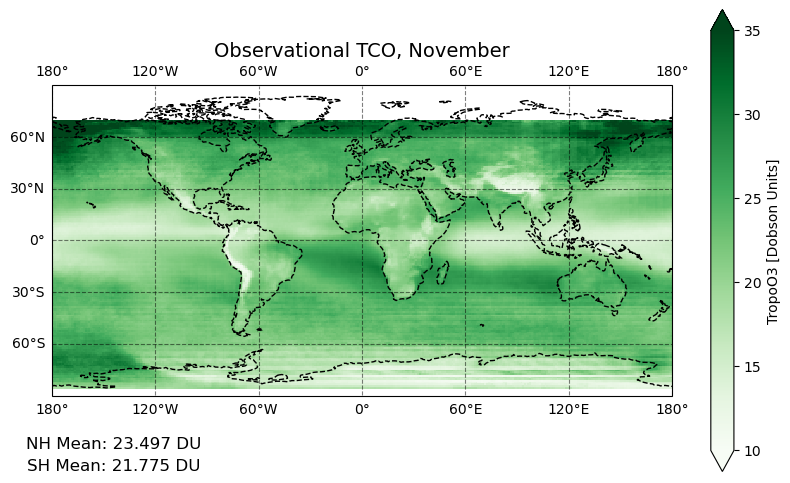

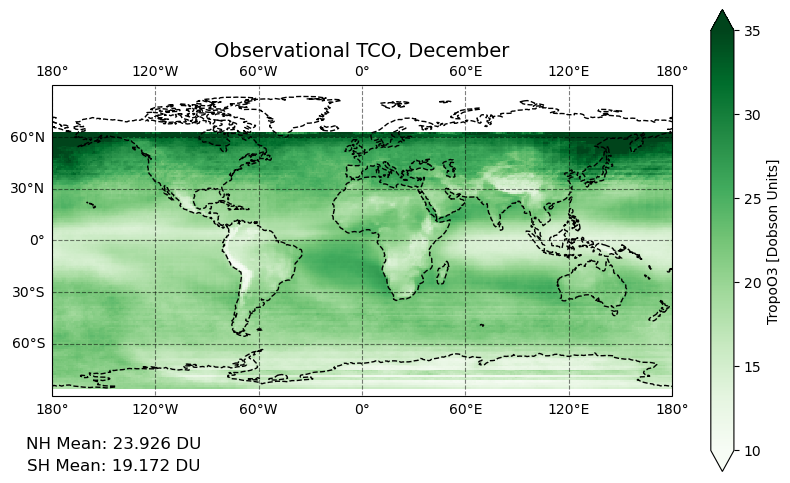

In [14]:
# plot the monthly means

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

for i in range(12):
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    monthly_mean[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=0), 
                         x='longitude', y='latitude', vmin=10, vmax=35, extend='both', cmap='Greens')
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    # adding gridlines
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.right_labels = False

    ax.set_title('Observational TCO, ' + str(month_list[i]), fontsize=14)
    
    # adding textual info
    nh_formatted_mean = f"{monthly_mean[i].sel(latitude=slice(0,90)).mean(dim={'latitude','longitude'}, skipna=True).data:.3f}"
    ax.text(0.10, -0.18, 'NH Mean: ' + str(nh_formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    
    sh_formatted_mean = f"{monthly_mean[i].sel(latitude=slice(-90,0)).mean(dim={'latitude','longitude'}, skipna=True).data:.3f}"
    ax.text(0.10, -0.25, 'SH Mean: ' + str(sh_formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)

    #plt.savefig("figures/Monthly_Mean_TropoO3-" + str(alphabet[i]))
    plt.show()

In [15]:
plotting_module.create_gif('/glade/u/home/mvoncyga/workspace/figures/', "TropoO3climatology.gif", 1000, "Monthly_Mean_")

Now truncate to 60S-60N, add fill value, and save as NETCDF4 files

In [16]:
mean_netcdf_dataset = monthly_mean.sel(latitude=slice(-75.5,75.5))

stdev_netcdf_dataset = monthly_stdev.sel(latitude=slice(-75.5,75.5))

In [17]:
#mean_netcdf_dataset
#stdev_netcdf_dataset

In [18]:
mean_netcdf_dataset.fillna(-999)

<xarray.DataArray 'TropoO3' (month: 12, latitude: 152, longitude: 360)> Size: 3MB
array([[[  16.610928 ,   16.635612 ,   16.655369 , ...,   15.158942 ,
           15.331881 ,   15.250627 ],
        [  16.772608 ,   16.803436 ,   16.927177 , ...,   15.190026 ,
           15.270223 ,   15.335663 ],
        [  16.812292 ,   16.900846 ,   17.089277 , ...,   15.086402 ,
           15.072547 ,   15.1386595],
        ...,
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ]],

       [[  17.7043   ,   17.887877 ,   18.236958 , ...,   16.12961  ,
           15.977057 ,   15.949893 ],
        [  17.711636 ,   17.826044 ,   18.168581 , ...,   15.678398 ,
           15.762339 ,   15.831459 ],
        [  18.12853  ,   18.19189  ,   18.261696 , ...,   15.629116 ,
           15.709588 ,   15.715805 ],
...
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ]],

       [[  21.306644 ,   21.534334 ,   22.171347 , ...,   17.564814 ,
           17.567068 ,   17.449982 ],
        [  21.72311  ,   21.74591  ,   22.105104 , ...,   17.584597 ,
           17.333443 ,   17.199173 ],
        [  21.782862 ,   22.088297 ,   22.345867 , ...,   16.959076 ,
           16.663982 ,   16.613573 ],
        ...,
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ],
        [-999.       , -999.       , -999.       , ..., -999.       ,
         -999.       , -999.       ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -75.5 -74.5 -73.5 -72.5 ... 73.5 74.5 75.5
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone Mean, Ground to 300 hPa
    latitude:    -75.5, -59.5, -58.5, ..., 59.5, 75.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [19]:
#mean_netcdf_dataset.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024.nc",format="NETCDF4")

In [20]:
stdev_netcdf_dataset.fillna(-999)

<xarray.DataArray 'TropoO3' (month: 12, latitude: 152, longitude: 360)> Size: 3MB
array([[[ 1.4883140e+00,  1.2546980e+00,  9.9517590e-01, ...,
          1.5512474e+00,  1.4806232e+00,  1.4384158e+00],
        [ 1.4383551e+00,  1.3418806e+00,  1.3841609e+00, ...,
          1.3236319e+00,  1.2694534e+00,  1.1799153e+00],
        [ 1.5286313e+00,  1.4873599e+00,  1.6533293e+00, ...,
          1.3105993e+00,  1.2243972e+00,  1.2203419e+00],
        ...,
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]],

       [[ 1.8764802e+00,  2.0557868e+00,  1.7273605e+00, ...,
          1.8665925e+00,  1.7497228e+00,  1.7382605e+00],
        [ 1.9759082e+00,  2.1817517e+00,  2.0256555e+00, ...,
          1.7159221e+00,  1.7430605e+00,  1.8374991e+00],
        [ 2.2520952e+00,  2.3799927e+00,  2.2490752e+00, ...,
          1.8454915e+00,  1.8404026e+00,  1.7334585e+00],
...
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]],

       [[ 3.6807060e+00,  4.0592704e+00,  5.1392522e+00, ...,
          1.8333876e+00,  1.7312202e+00,  1.6018672e+00],
        [ 3.8299758e+00,  4.0318031e+00,  4.6413307e+00, ...,
          1.3951125e+00,  1.4749901e+00,  1.4831877e+00],
        [ 4.2063017e+00,  4.3421850e+00,  4.6122446e+00, ...,
          1.5254247e+00,  1.1890492e+00,  1.3278961e+00],
        ...,
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -75.5 -74.5 -73.5 -72.5 ... 73.5 74.5 75.5
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone STDEV, Ground to 300 hPa
    latitude:    -75.5, -59.5, -58.5, ..., 59.5, 75.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [21]:
#stdev_netcdf_dataset.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_stdev_2005_2024.nc",format="NETCDF4")

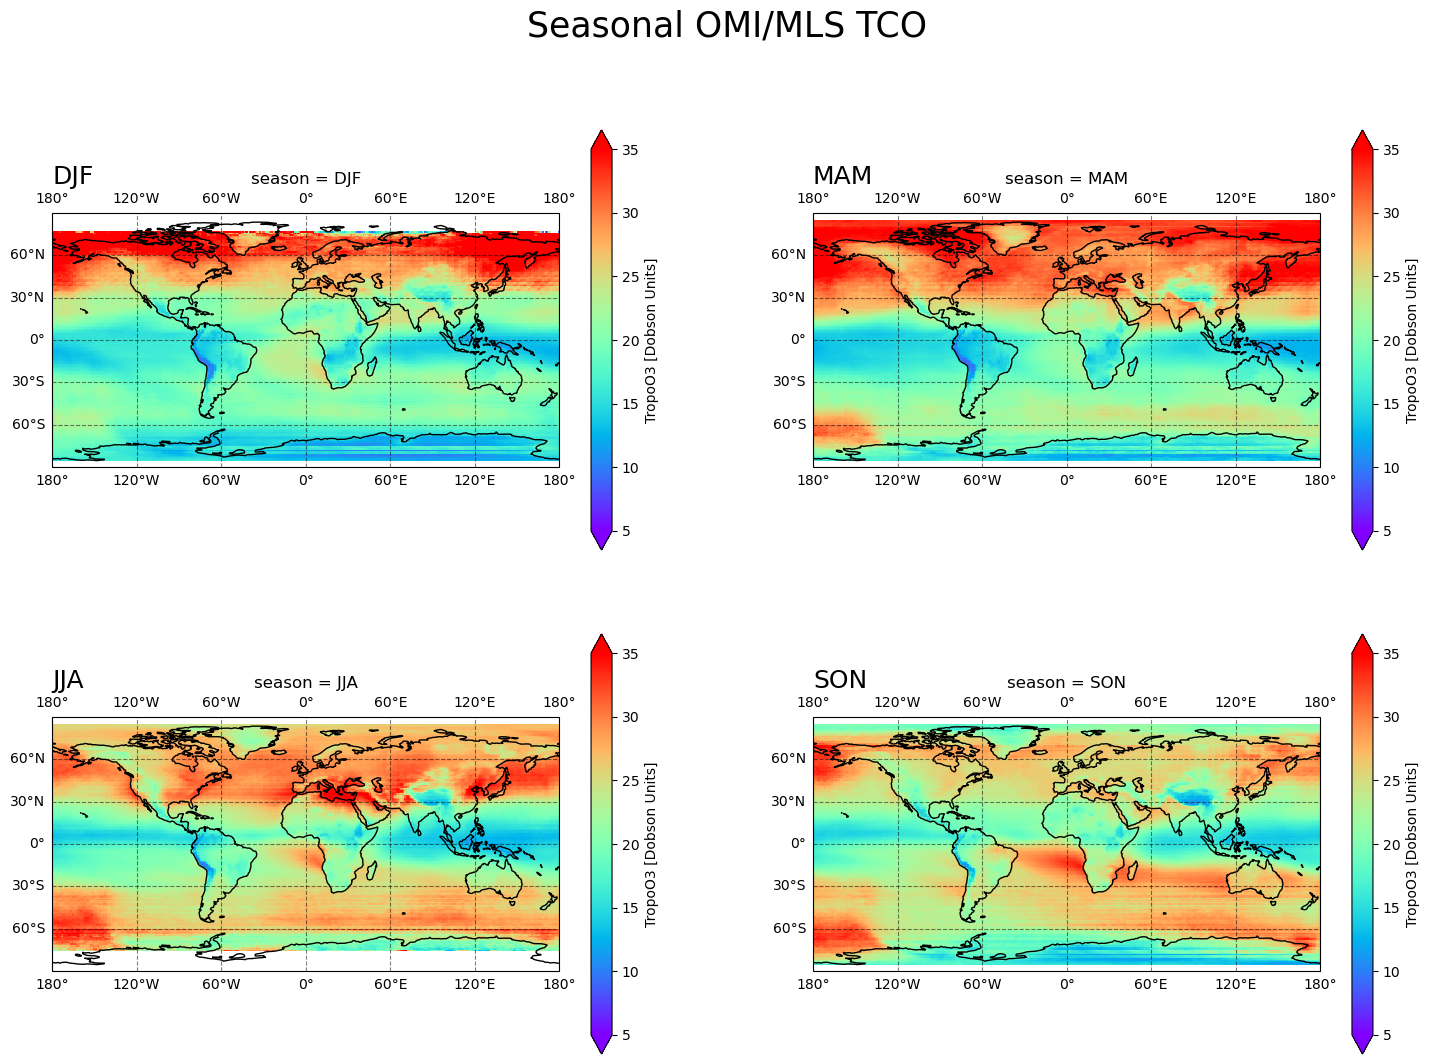

In [22]:
seasonal_list = ['DJF', 'JJA', 'MAM', 'SON']

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,12),subplot_kw={'projection': ccrs.PlateCarree()})

for axis in ['top','bottom','left','right']:
    for i in range(2):
        for j in range(2):
            ax[i][j].spines[axis].set_linewidth(1.5)

ax1 = ax[0, 0]
ax[0][0].set_title(str(seasonal_list[0]), fontsize=18, loc='left')
seasonal_mean[0].plot(ax=ax[0][0],transform=ccrs.PlateCarree(central_longitude=0), vmin=5, vmax=35, extend='both',cmap='rainbow')
ax1.coastlines()
gl = ax[0][0].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False

ax2 = ax[1, 0]
ax[1][0].set_title(str(seasonal_list[1]), fontsize=18, loc='left')
ax2.set_title(seasonal_list[1])
seasonal_mean[1].plot(ax=ax[1,0], transform=ccrs.PlateCarree(central_longitude=0), vmin=5, vmax=35, extend='both',cmap='rainbow')
ax2.coastlines()
gl = ax[1][0].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False

ax3 = ax[0, 1]
ax[0][1].set_title(str(seasonal_list[2]), fontsize=18, loc='left')
ax3.set_title(seasonal_list[2])
seasonal_mean[2].plot(ax=ax[0,1], transform=ccrs.PlateCarree(central_longitude=0), vmin=5, vmax=35, extend='both',cmap='rainbow')
ax3.coastlines()
gl = ax[0][1].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False

ax4 = ax[1, 1]
ax[1][1].set_title(str(seasonal_list[3]), fontsize=18, loc='left')
ax4.set_title(seasonal_list[3])
seasonal_mean[3].plot(ax=ax[1][1], transform=ccrs.PlateCarree(central_longitude=0), vmin=5, vmax=35, extend='both',cmap='rainbow')
ax4.coastlines()
gl = ax[1][1].gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
gl.right_labels = False


fig.suptitle('Seasonal OMI/MLS TCO', fontsize=25)
fig.tight_layout

#plt.savefig("figures/observational_seasonal_climatology")
plt.show()

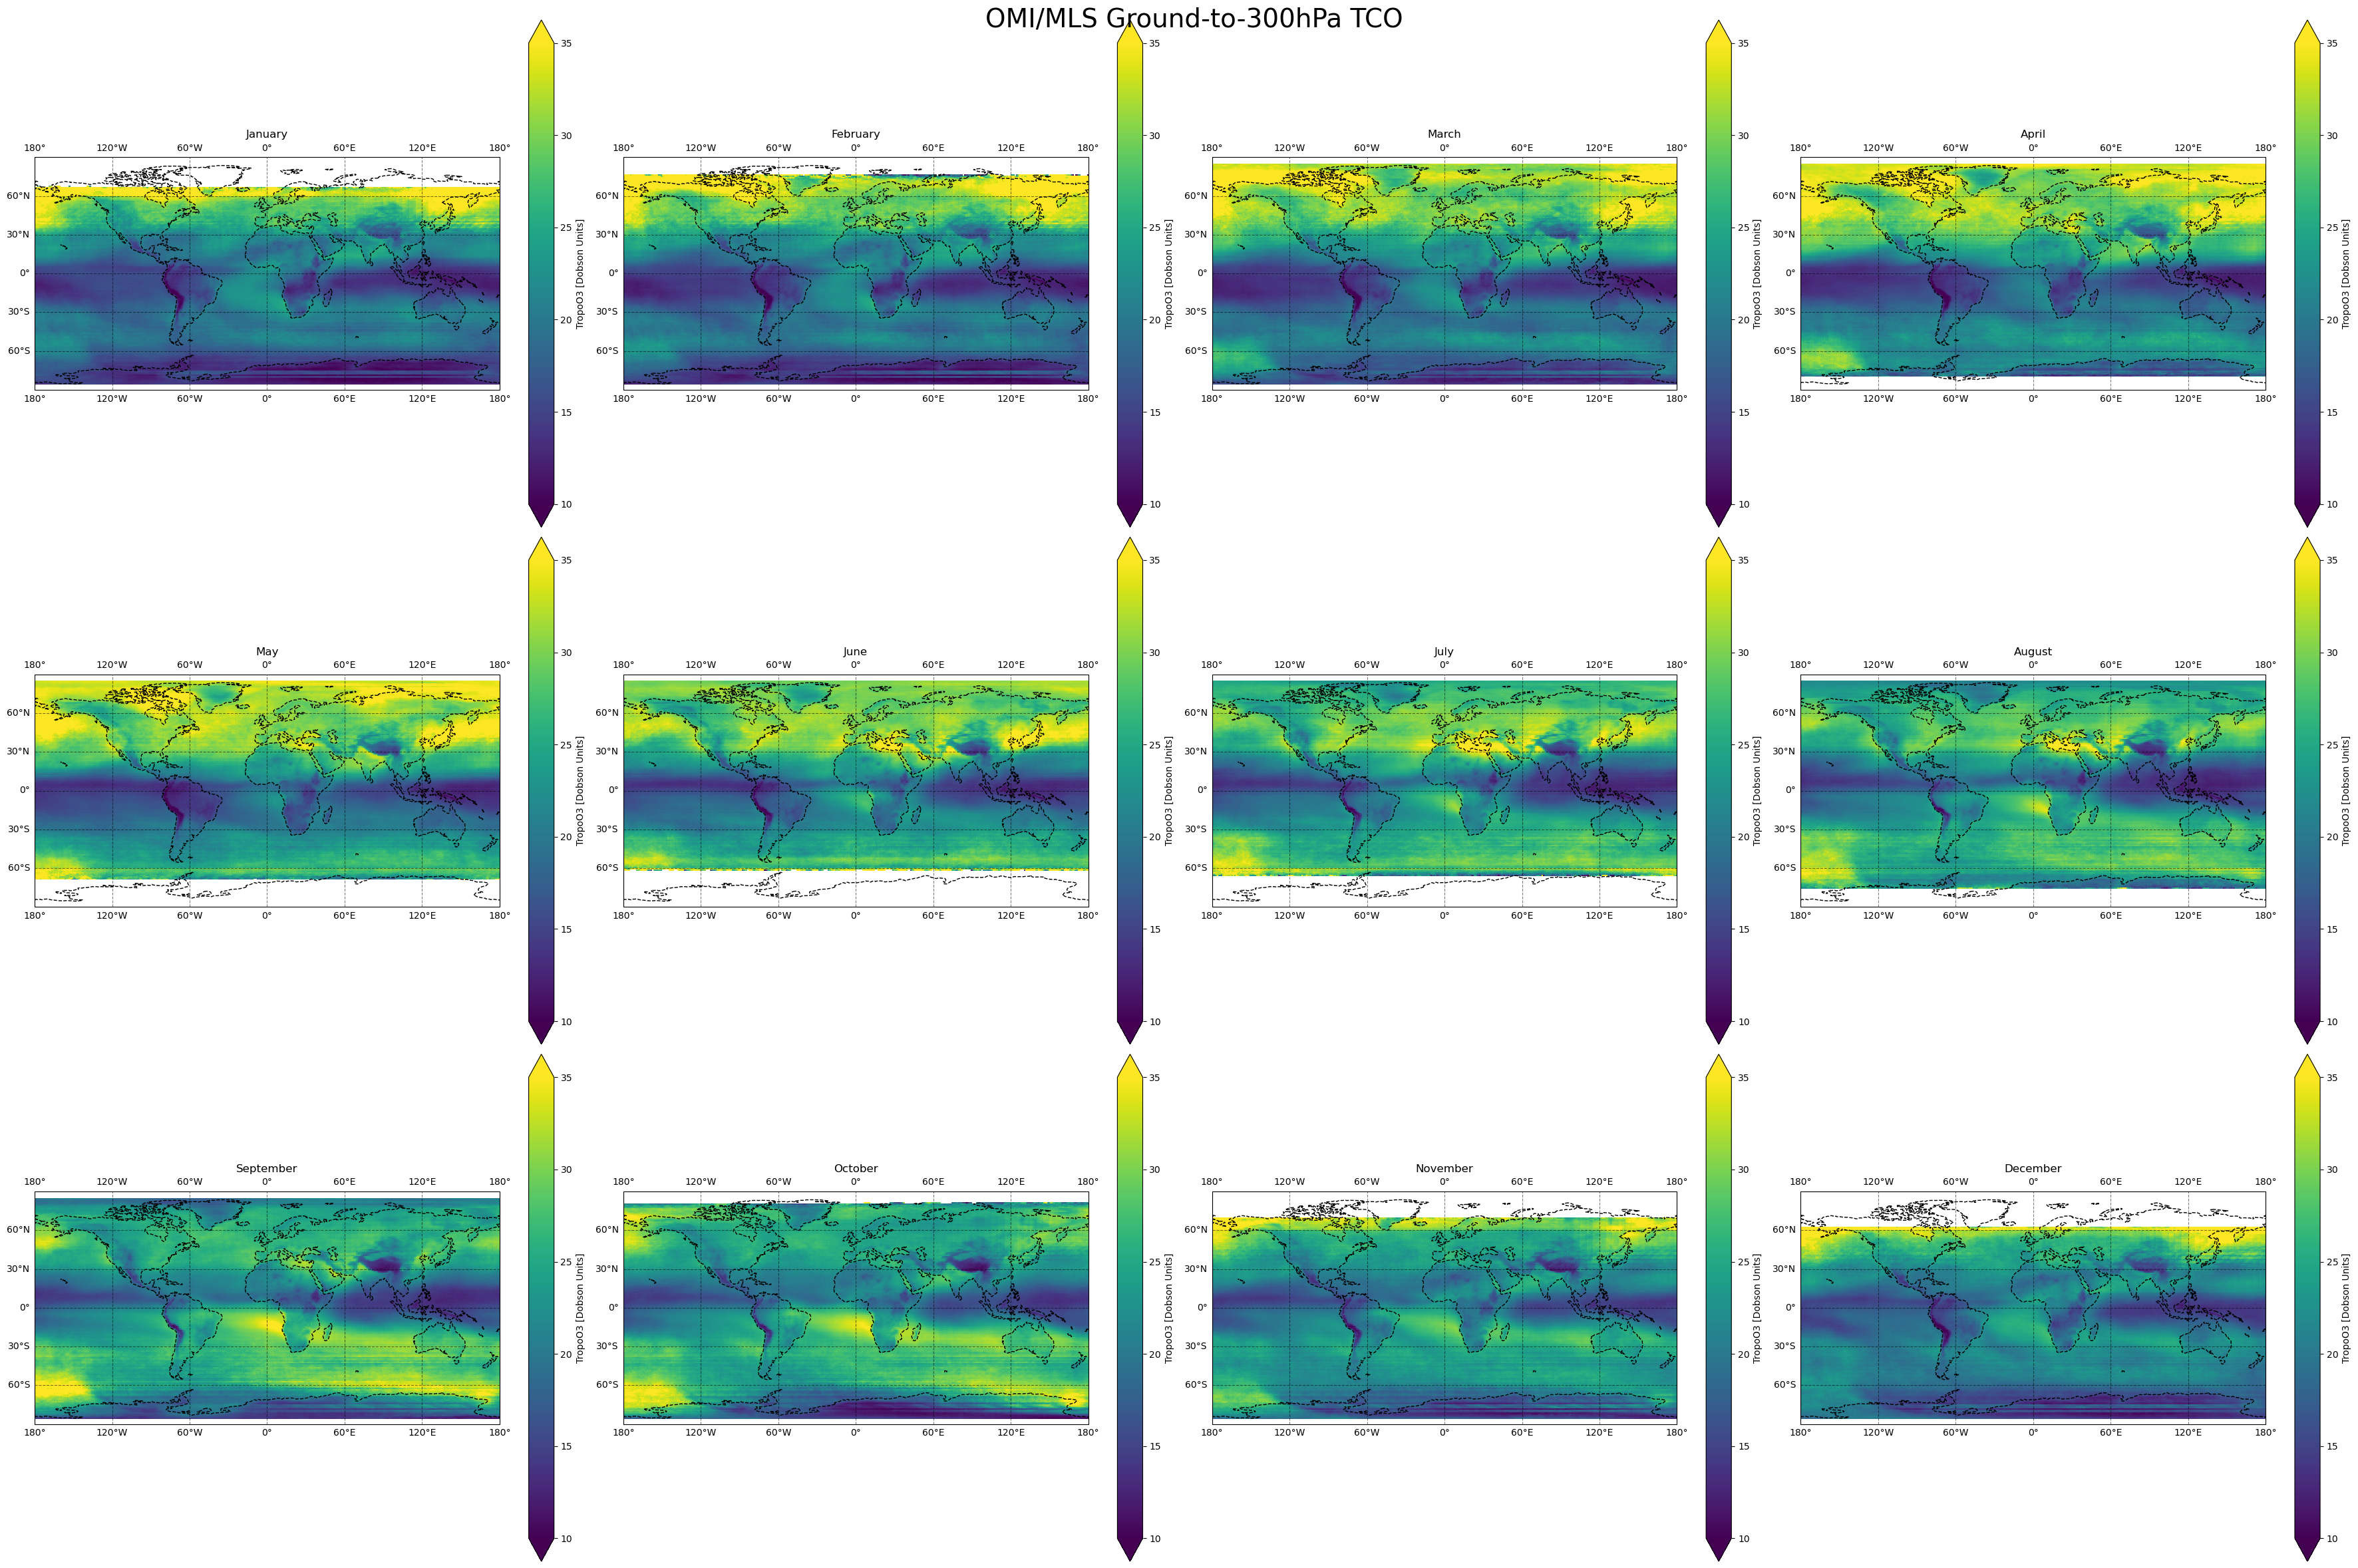

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(36, 24), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, ax in enumerate(axes.ravel()):
    #ax.spines[axis].set_linewidth(100.5)
    monthly_mean[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=0), vmin=10, vmax=35, extend='both', cmap='viridis')
    ax.set_global()
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.right_labels = False

    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_title(f'{month_list[i]}')
    fig.suptitle('OMI/MLS Ground-to-300hPa TCO', fontsize=28)
    plt.tight_layout()


#plt.savefig("figures/OMIMLS_Monthly_Climatology_300hPa")
plt.show()